In [1]:
import pickle 
import numpy as np
import pandas as pd
from epiweeks import Week
from datetime import datetime
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor

from utils import get_cases, get_data_slice, get_epiweek, SprintModel, plot_coef, get_forecast_X

In [2]:
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
data = pd.read_csv('../data/dengue_uf.csv.gz')

data.head()

uf        date  casos
0  AC  2010-01-03    869
1  AC  2010-01-10   1003
2  AC  2010-01-17   1010
3  AC  2010-01-24   1397
4  AC  2010-01-31   2000

Class that create a custom regression model to be used in the stacking based on the predictions sent to mosqlimate api.

In [4]:
df_preds_all = pd.read_csv('../predictions/preds_models.csv.gz', index_col = 'Unnamed: 0')
df_preds_all = df_preds_all.rename(columns = {'adm_1': 'state'})
df_preds_all.head()

date        pred       lower       upper state  model_id
0  2022-10-09  110.690113   64.291013  219.826948    AC        21
1  2022-10-16  144.952846   77.564037  279.722708    AC        21
2  2022-10-23  163.613937   92.915072  276.591399    AC        21
3  2022-10-30  170.240443   87.197631  378.407811    AC        21
4  2022-11-06  215.117888  111.835667  445.024983    AC        21

In [5]:
models_by_state = df_preds_all.groupby('state')['model_id'].agg(lambda x: list(set(x))).reset_index()
models_by_state.head()

state                  model_id
0    AC  [34, 21, 22, 27, 28, 30]
1    AL  [34, 21, 22, 27, 28, 30]
2    AM  [34, 21, 22, 27, 28, 30]
3    AP  [34, 21, 22, 27, 28, 30]
4    BA  [34, 21, 22, 27, 28, 30]

### Ensembling of the mandatory states: 

/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690:

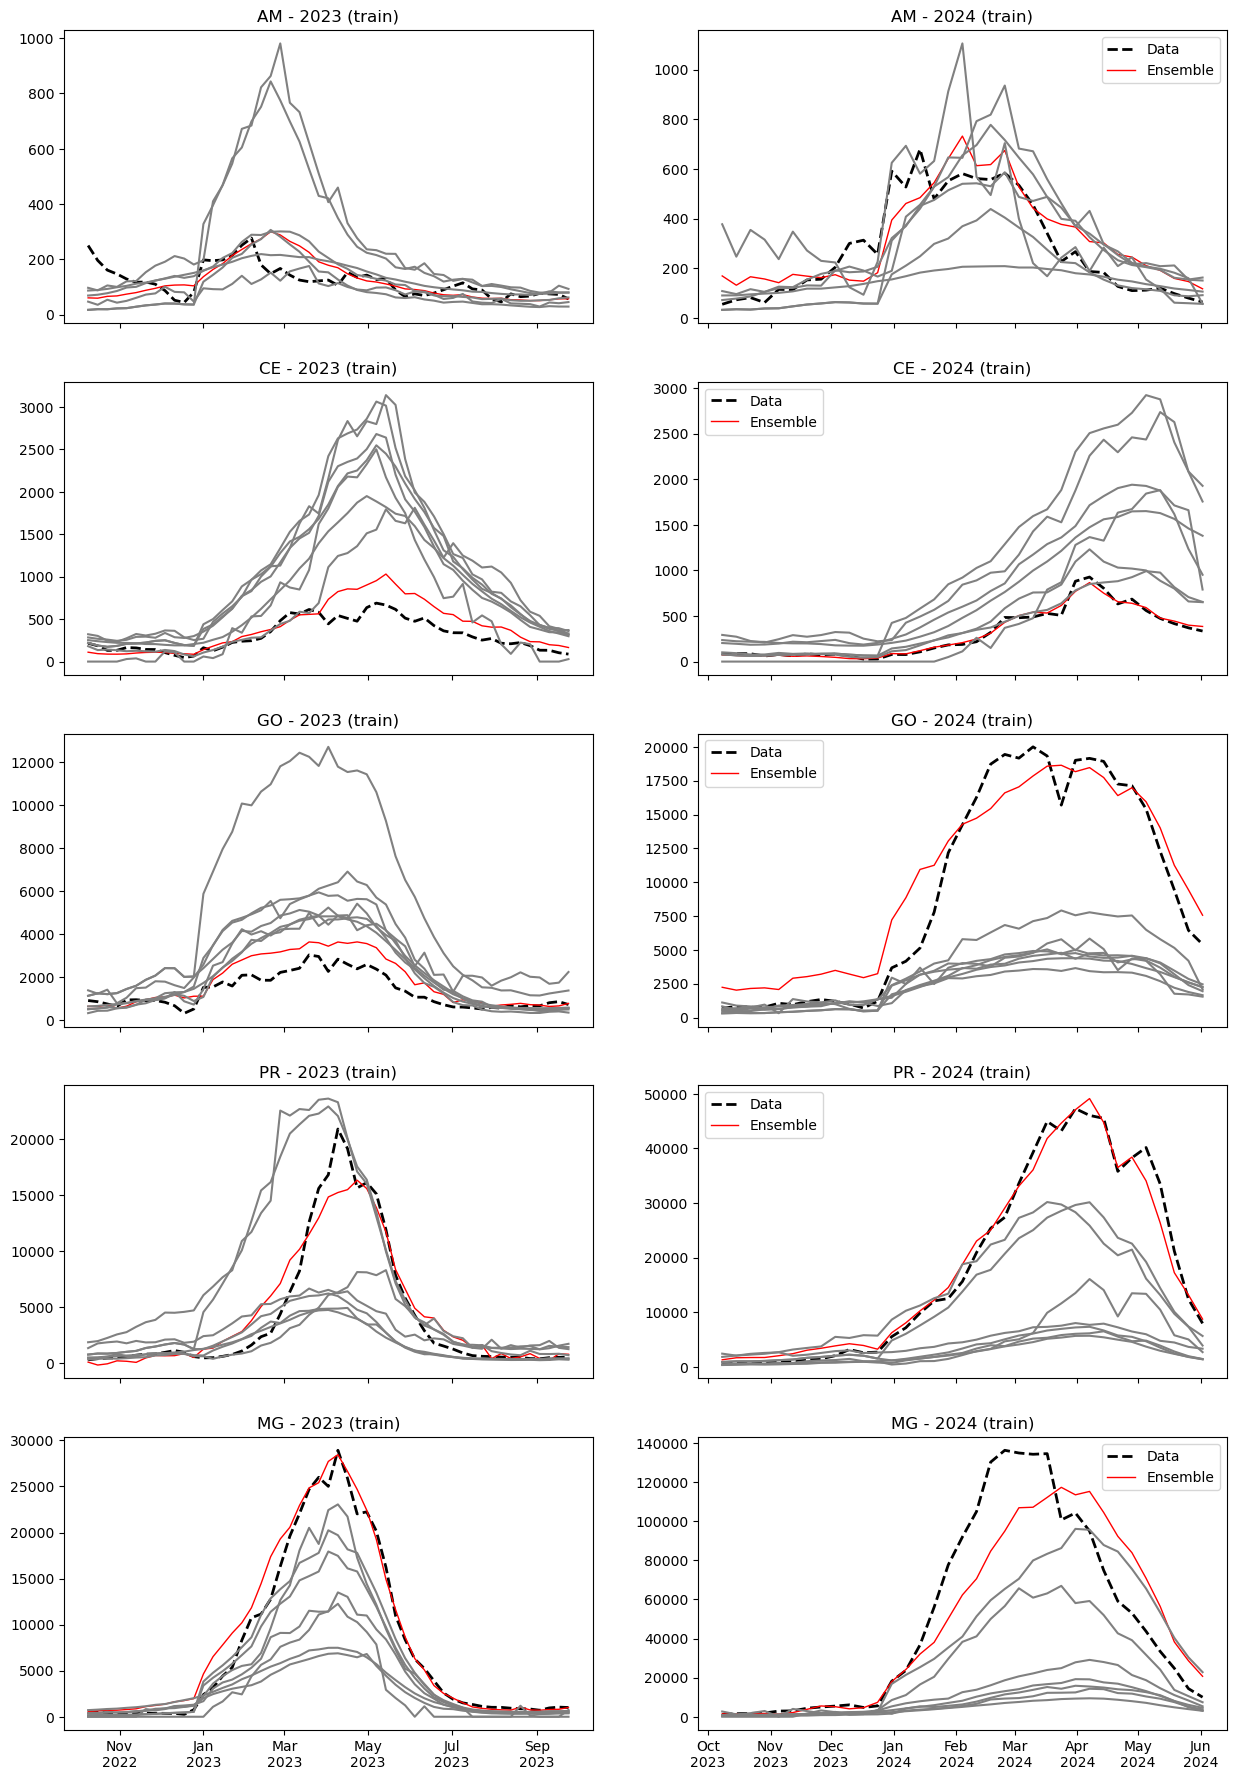

CPU times: user 9.2 s, sys: 406 ms, total: 9.61 s
Wall time: 9.67 s


In [6]:
%%time
fig, axs  = plt.subplots(5,2, figsize = (15, 25))
ax = axs.ravel()

i = 0
for state in ['AM', 'CE', 'GO', 'PR', 'MG']: 

    X, y = get_data_slice(data, state, start_date = Week(2022, 41).startdate().strftime('%Y-%m-%d'),
                              end_date = Week(2023, 39).startdate().strftime('%Y-%m-%d'))
    

    estimators = []
    
    for model_id in models_by_state.loc[models_by_state.state == state ]['model_id'].values[0]:
    
         estimators.append((f'{model_id}', SprintModel(model_id = model_id,
                                                      state = state)))

    
        
    stack = StackingRegressor(
        estimators=estimators,
        final_estimator=MLPRegressor()
    )
    
    stack.fit(X.values, y)
    stack_preds = stack.predict(X.values)

    dates_23 = pd.date_range(start= Week(2022, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2023, 39).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    ax[i].plot(dates_23, y, color = 'black', linestyle='--', label = 'Data', linewidth = 2)
    ax[i].plot(dates_23, stack_preds, color = 'red', label = 'Ensemble', linewidth = 1)
    
    preds23 = np.empty((0, 51))

    for model in estimators:
    
        preds23 = np.append(preds23, model[1].predict(X.values).reshape(1,-1),axis = 0)

    ax[i].plot(dates_23, preds23.T,
               color = 'grey')
    
    ax[i].set_title(f'{state} - 2023 (train)')

    
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'

    with open(f'../saved_models/stacking_regressor_{state}_2023.pkl', 'wb') as f:
        pickle.dump(stack, f)
            

    X, y = get_data_slice(data, state, start_date = Week(2023, 41).startdate().strftime('%Y-%m-%d'),
                          end_date = '2024-06-02')

    stack = StackingRegressor(
        estimators=estimators,
        final_estimator= MLPRegressor(hidden_layer_sizes=(100,))
    )
    
    stack.fit(X.values, y)
    stack_preds = stack.predict(X.values)

    with open(f'../saved_models/stacking_regressor_{state}_2024.pkl', 'wb') as f:
        pickle.dump(stack, f)
            
    
    dates_24 = pd.date_range(start= Week(2023, 41).startdate().strftime('%Y-%m-%d'),
                  end= '2024-06-02',
                  freq='W-SUN')

    ax[i+1].plot(dates_24, y, color = 'black', linestyle='--', label = 'Data', linewidth = 2)

    ax[i+1].plot(dates_24, stack_preds, color = 'red', label = 'Ensemble', linewidth = 1)

    preds24 = np.empty((0, 35))

    for model in estimators:
    
        preds24 = np.append(preds24, model[1].predict(X.values).reshape(1,-1),axis = 0)

    ax[i+1].plot(dates_24, preds24.T,
               color = 'grey')
                 
    ax[i+1].legend()
    
    ax[i+1].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'
            
    ax[i+1].set_title(f'{state} - 2024 (train)')


    i = i+2

# Rotate the date labels for better readability
fig.autofmt_xdate(rotation=0, ha='center')

#plt.savefig('ensemble_final.png', dpi = 600, bbox_inches = 'tight')

plt.show()


### Generate the scenarios 

In [7]:
X_for = get_forecast_X(start_date= Week(2024, 41).startdate().strftime('%Y-%m-%d'),
                      end_date= Week(2025, 40).startdate().strftime('%Y-%m-%d'),)

In [8]:
X_for.head()

epi_year  epi_week
0      2024        41
1      2024        42
2      2024        43
3      2024        44
4      2024        45

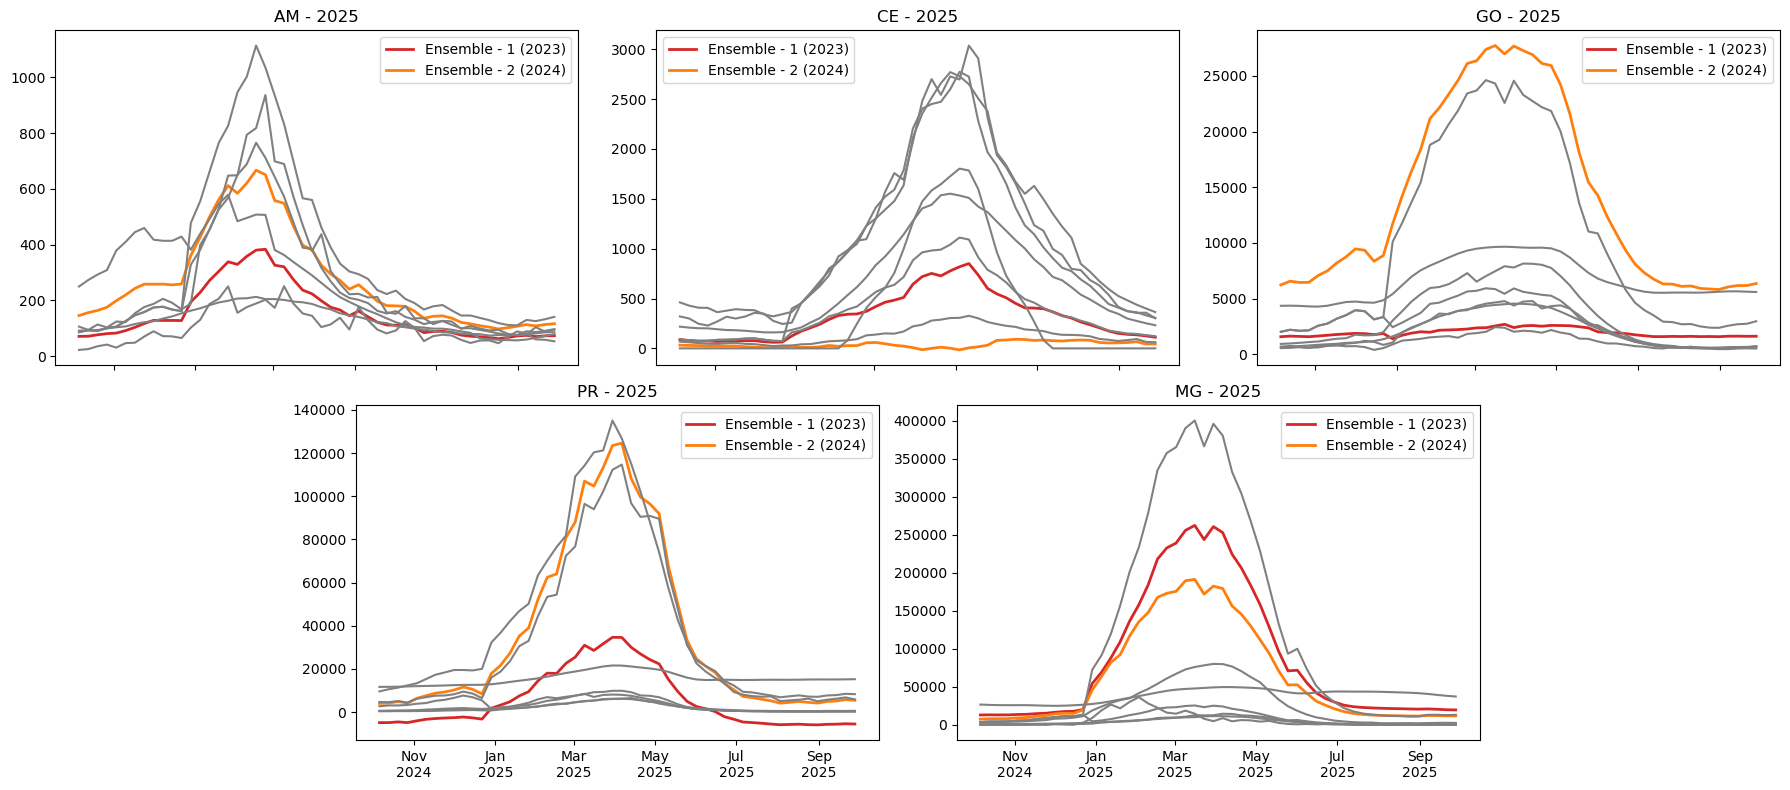

CPU times: user 3.43 s, sys: 159 ms, total: 3.59 s
Wall time: 3.71 s


In [9]:
%%time
fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(2, 6, figure=fig)
    
# First row with three boxplots
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
    
# Second row with two boxplots
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

i = 0
for state, ax in zip(['AM', 'CE', 'GO', 'PR', 'MG'], 
                     [ax1,ax2,ax3,ax4,ax5]): 

    with open(f'../saved_models/stacking_regressor_{state}_2023.pkl', 'rb') as f:
        stack_23 = pickle.load(f)

    with open(f'../saved_models/stacking_regressor_{state}_2024.pkl', 'rb') as f:
        stack_24 = pickle.load(f)
        
    estimators = []
    
    for model_id in models_by_state.loc[models_by_state.state == state ]['model_id'].values[0]:
    
         estimators.append((f'{model_id}', SprintModel(model_id = model_id,
                                                      state = state)))


    stack_25_23 = stack_23.predict(X_for.values)
    stack_25_24 = stack_24.predict(X_for.values)
    
    dates_25 = pd.date_range(start= Week(2024, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2025, 40).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    ax.plot(dates_25, stack_25_23, color = 'tab:red', label = 'Ensemble - 1 (2023)', linewidth = 2)
    ax.plot(dates_25, stack_25_24, color = 'tab:orange', label = 'Ensemble - 2 (2024)', linewidth = 2)
    
    preds25 = np.empty((0, 52))

    for model in estimators:
    
        preds25 = np.append(preds25, model[1].predict(X_for.values).reshape(1,-1),axis = 0)

    ax.plot(dates_25, preds25.T,
               color = 'grey')
    
    ax.set_title(f'{state} - 2025')

    ax.legend()

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'

    i = i+1

# Rotate the date labels for better readability
fig.autofmt_xdate(rotation=0, ha='center')


plt.tight_layout()
plt.savefig('../figures/ensemble_stack_final.png', dpi = 600, bbox_inches = 'tight')

plt.show()


### Train model for all the states: 

In [10]:
states_ne = ['AL', 'BA', 'MA', 'PB', 'PE', 'PI', 'SE', 'RN']
states_se = ['SP', 'RJ', 'ES']
states_sul = ['RS', 'SC']
states_ce = ['DF', 'MT', 'MS']
states_no = ['AP', 'TO', 'RR', 'RO' ,'AC', 'PA']

states_BR = states_ne+states_se+states_no+states_ce+states_sul

In [11]:
%%time
for state in states_BR: 

    X, y = get_data_slice(data, state, start_date = Week(2022, 41).startdate().strftime('%Y-%m-%d'),
                              end_date = Week(2023, 39).startdate().strftime('%Y-%m-%d'))
    

    estimators = []
    
    for model_id in models_by_state.loc[models_by_state.state == state ]['model_id'].values[0]:
    
         estimators.append((f'{model_id}', SprintModel(model_id = model_id,
                                                      state = state)))

        
    stack = StackingRegressor(
        estimators=estimators,
        final_estimator=MLPRegressor()
    )
    
    stack.fit(X.values, y)
    #stack_preds = stack.predict(X.values)

    with open(f'../saved_models/stacking_regressor_{state}_2023.pkl', 'wb') as f:
        pickle.dump(stack, f)     

    X, y = get_data_slice(data, state, start_date = Week(2023, 41).startdate().strftime('%Y-%m-%d'),
                          end_date = '2024-06-02')

    stack = StackingRegressor(
        estimators=estimators,
        final_estimator= MLPRegressor(hidden_layer_sizes=(100,))
    )
    
    stack.fit(X.values, y)
    stack_preds = stack.predict(X.values)

    with open(f'../saved_models/stacking_regressor_{state}_2024.pkl', 'wb') as f:
        pickle.dump(stack, f)
            

/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690:

CPU times: user 31.7 s, sys: 2.11 s, total: 33.8 s
Wall time: 40.2 s


/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Applying for all the states:

In [12]:

df_forecast = pd.DataFrame()

for state in ['AM', 'CE', 'GO', 'MG', 'PR']: 
        
    with open(f'../saved_models/stacking_regressor_{state}_2023.pkl', 'rb') as f:
        stack_23 = pickle.load(f)

    with open(f'../saved_models/stacking_regressor_{state}_2024.pkl', 'rb') as f:
        stack_24 = pickle.load(f)

    stack_25_23 = stack_23.predict(X_for.values)
    stack_25_24 = stack_24.predict(X_for.values)
    
    dates_25 = pd.date_range(start= Week(2024, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2025, 40).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')


    df_for = pd.DataFrame()

    df_for['date'] = dates_25
    df_for['ensemble_2023'] = stack_25_23
    df_for['ensemble_2024'] = stack_25_24

    df_for.set_index('date', inplace = True)

    df_for['state'] = state

    df_forecast = pd.concat([df_forecast, df_for])


In [14]:
df_forecast.state.value_counts()

state
AM    52
CE    52
GO    52
MG    52
PR    52
Name: count, dtype: int64

In [15]:
df_forecast.to_csv('../predictions/ensemble_mandatory.csv')

In [16]:
df_forecast.isnull().sum()

ensemble_2023    0
ensemble_2024    0
state            0
dtype: int64

In [17]:
states_ne = ['AL', 'BA','MA', 'PB', 'PE', 'PI', 'SE', 'RN']
states_se = ['SP',  'RJ', 'ES']
states_sul = ['RS', 'SC',]
states_ce = ['DF', 'MT', 'MS']
states_no = ['AP', 'TO', 'RR', 'RO' ,'AC', 'PA']

states_BR = states_ne+states_se+states_no+states_ce+states_sul


In [18]:

df_forecast = pd.DataFrame()

for state in states_BR: 
        
    with open(f'../saved_models/stacking_regressor_{state}_2023.pkl', 'rb') as f:
        stack_23 = pickle.load(f)

    with open(f'../saved_models/stacking_regressor_{state}_2024.pkl', 'rb') as f:
        stack_24 = pickle.load(f)

    stack_25_23 = stack_23.predict(X_for.values)
    stack_25_24 = stack_24.predict(X_for.values)
    
    dates_25 = pd.date_range(start= Week(2024, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2025, 40).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')


    df_for = pd.DataFrame()

    df_for['date'] = dates_25
    df_for['ensemble_2023'] = stack_25_23
    df_for['ensemble_2024'] = stack_25_24

    df_for.set_index('date', inplace = True)
    
    df_for['state'] = state

    df_forecast = pd.concat([df_forecast, df_for])


In [19]:
df_forecast.isnull().sum()

ensemble_2023    0
ensemble_2024    0
state            0
dtype: int64

In [21]:
df_forecast.to_csv('../predictions/ensemble.csv')

### Plot the forecasts: 

In [18]:
df_forecast = pd.read_csv('./predictions/ensemble_mandatory.csv')
df_forecast.date = pd.to_datetime(df_forecast.date)
df_forecast.head()

date  ensemble_2023  ensemble_2024    pred_21   lower_21   upper_21  \
0 2024-10-06      53.686432     193.377451   2.448956   0.000000  10.572246   
1 2024-10-13      59.639040     214.101514  36.220227  18.395518  58.050820   
2 2024-10-20      54.658247     191.590746   6.113500   0.000000  20.626536   
3 2024-10-27      59.040944     210.347825  10.054739   2.650930  22.254004   
4 2024-11-03      77.318481     264.660846  57.966262  37.272050  89.608984   

   pred_22  lower_22  upper_22  pred_25  ...     pred_28    lower_28  \
0    250.0      50.0   1215.00      0.0  ...  304.548882  289.177075   
1    273.5      55.0   1314.95      0.0  ...  320.274210  304.466262   
2    293.0      59.0   1412.00      0.0  ...  281.495668  266.771467   
3    309.0      61.0   1481.00      0.0  ...  312.579643  296.984046   
4    379.0      72.0   1819.95      0.0  ...  374.479146  357.240114   

     upper_28  pred_30  lower_30  upper_30     pred_33  lower_33    upper_33  \
0  320.516222     92.0      31.0     236.0  113.381844       0.0  382.872380   
1  336.683725     92.5      33.0     250.0  100.796089       0.0  370.286625   
2  296.808201     94.0      36.0     260.0  118.322297       0.0  387.812833   
3  328.771726    100.0      38.0     277.0  108.368372       0.0  377.858908   
4  392.326560    104.0      38.0     275.0  129.020374       0.0  398.510910   

   state  
0     AM  
1     AM  
2     AM  
3     AM  
4     AM  

[5 rows x 25 columns]

In [40]:
import seaborn as sns
df_preds_all.date = pd.to_datetime(df_preds_all.date)


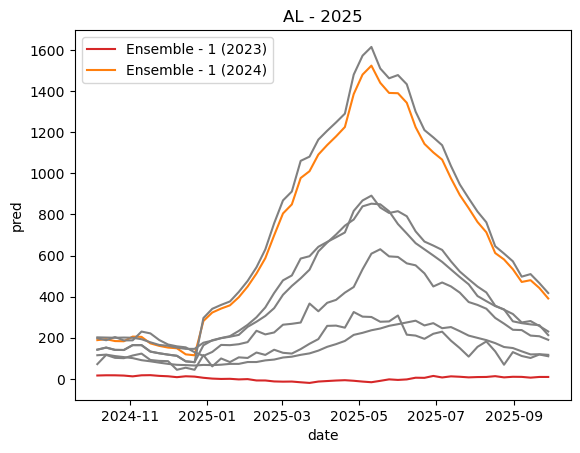

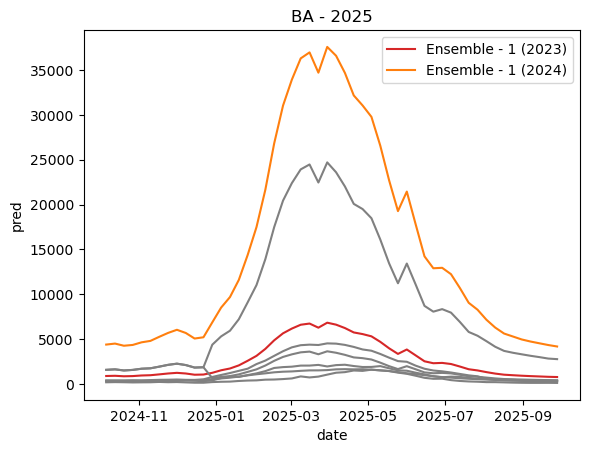

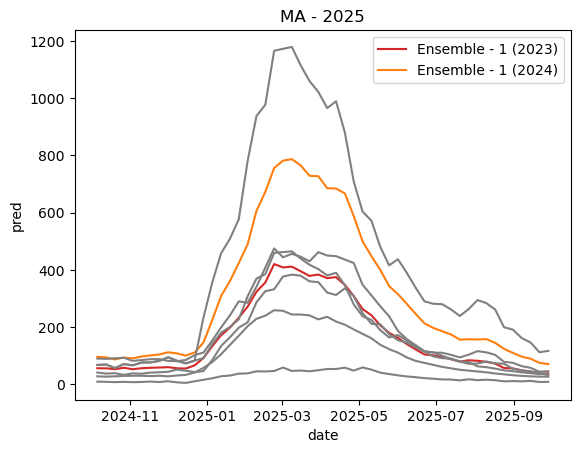

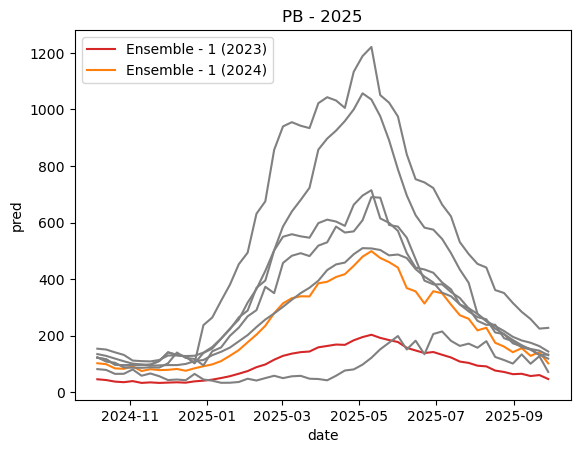

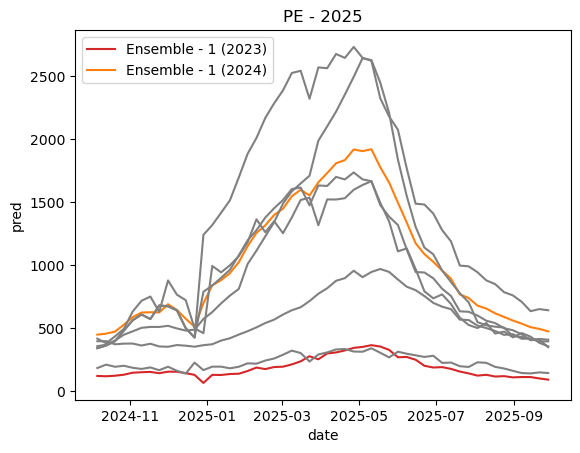

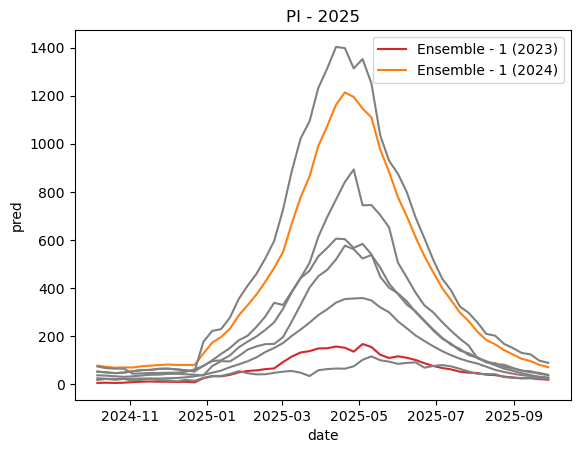

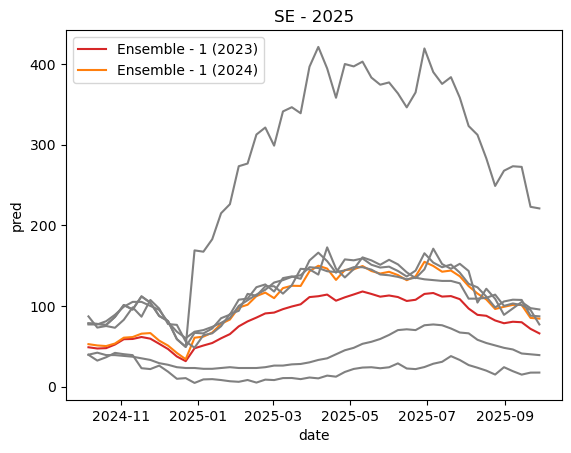

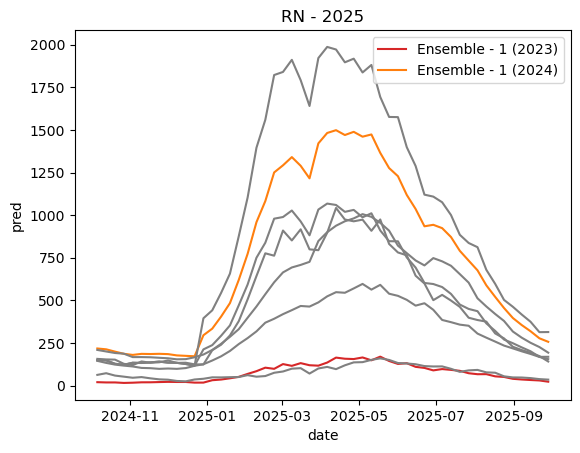

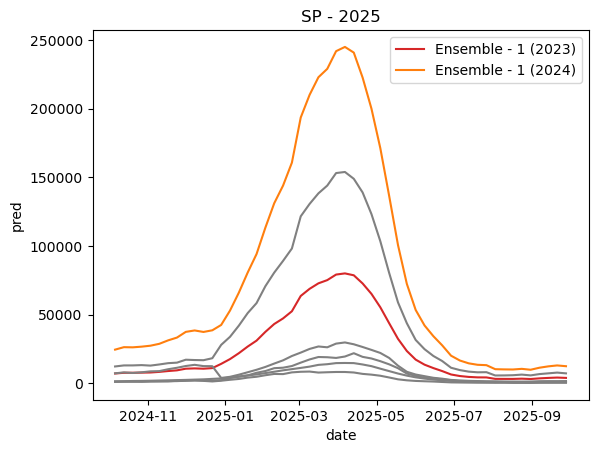

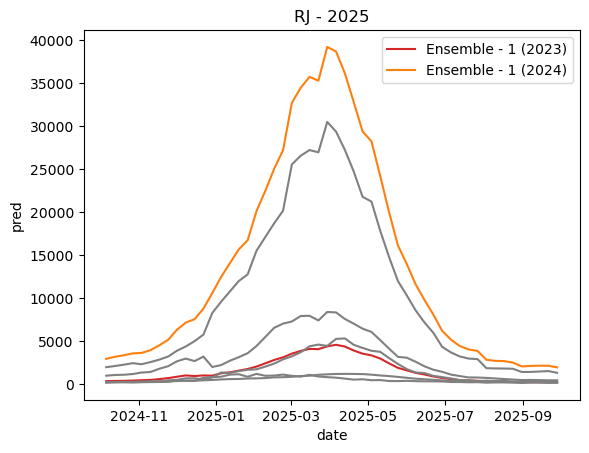

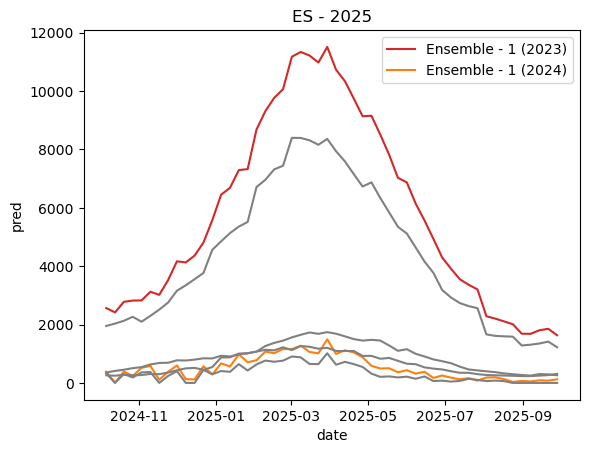

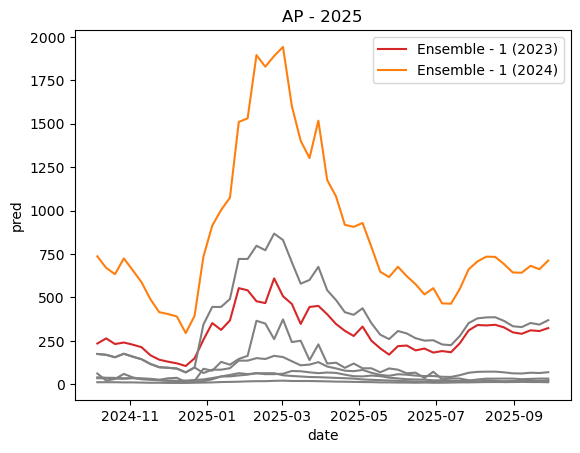

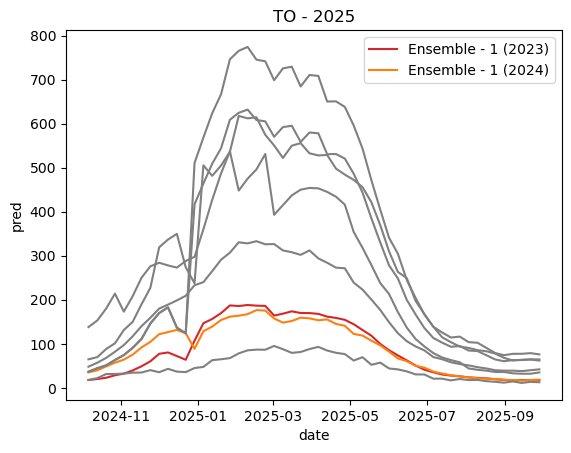

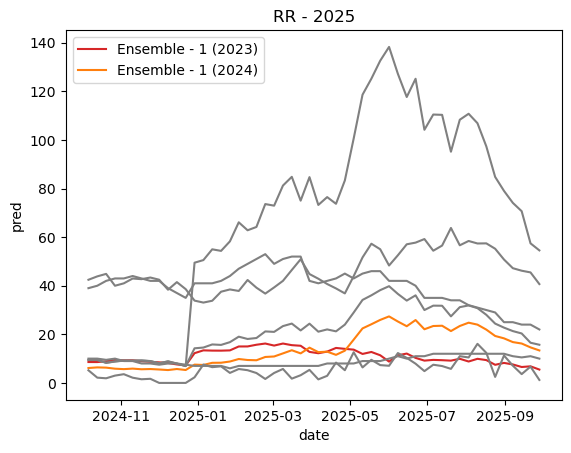

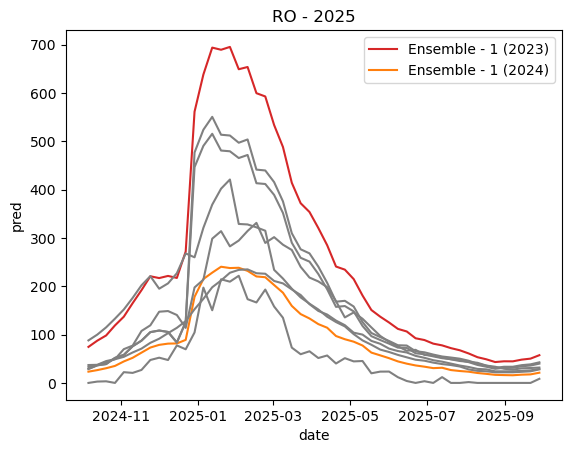

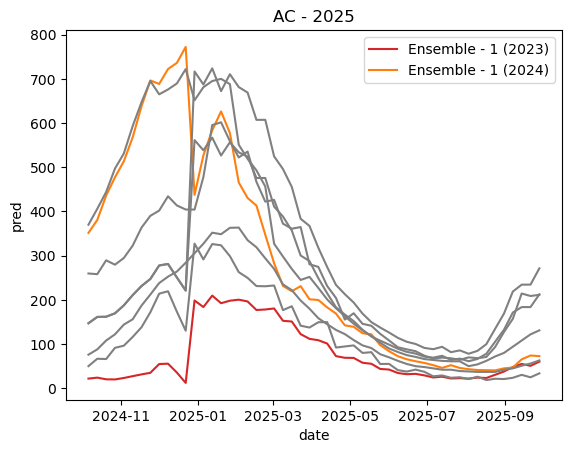

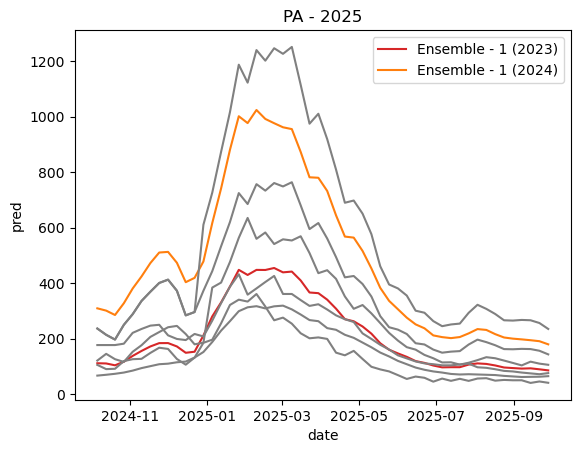

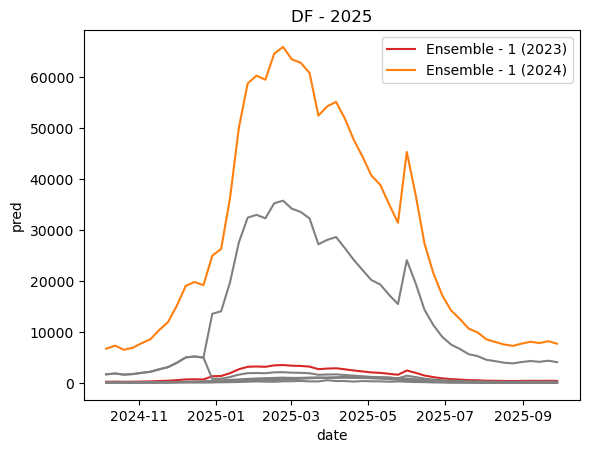

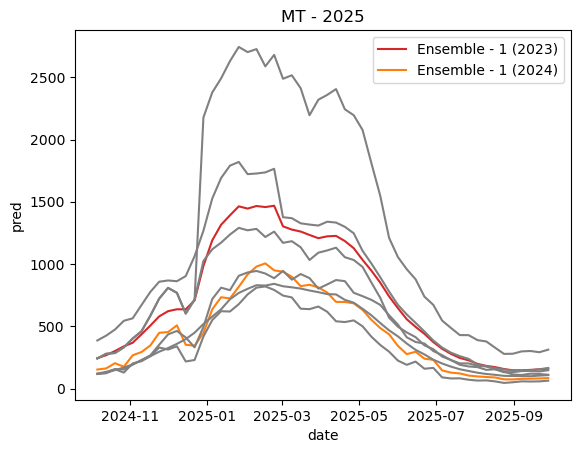

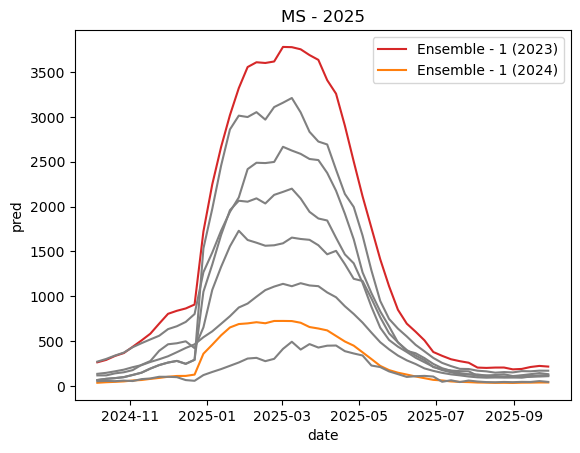

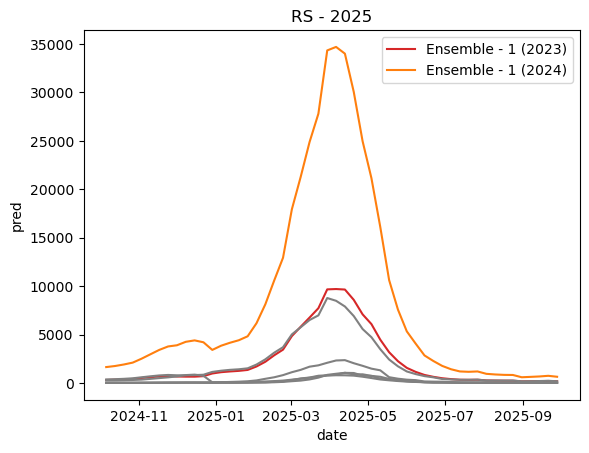

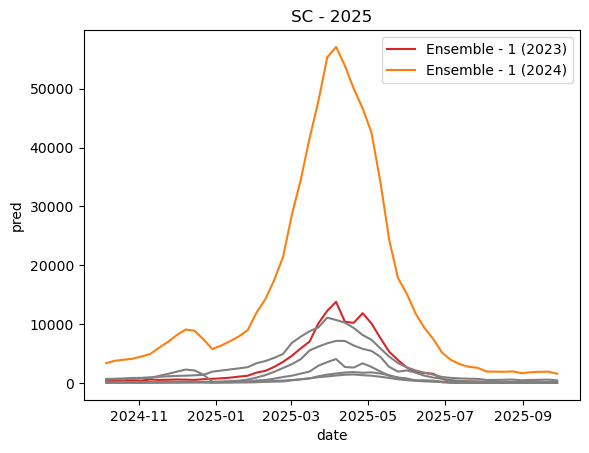

In [45]:
for state in df_forecast.state.unique(): 

    df_ = df_forecast.loc[df_forecast.state == state] 
    fig,ax = plt.subplots()

    ax.plot(df_.index, df_.ensemble_2023, color = 'tab:red', label = 'Ensemble - 1 (2023)', linewidth = 1.5)

    ax.plot(df_.index, df_.ensemble_2024, color = 'tab:orange', label = 'Ensemble - 1 (2024)', linewidth = 1.5)

    sns.lineplot(ax=ax, x = 'date', y = 'pred',   legend = False, units="model_id", estimator=None, 
         color = 'grey', data = df_preds_all.loc[(df_preds_all.date.isin(dates_25)) & (df_preds_all.state == state)])
    
    ax.set_title(f'{state} - 2025')

    ax.legend()

    #plt.savefig(f'../figures/ensemble_{state}.png')
    
    plt.show()


In [46]:
df_forecast = pd.read_csv('../predictions/ensemble.csv')
df_forecast.date = pd.to_datetime(df_forecast.date)
df_forecast.head()

date  ensemble_2023  ensemble_2024 state
0 2024-10-06      16.448600     188.541875    AL
1 2024-10-13      17.578995     193.241507    AL
2 2024-10-20      17.434195     183.913835    AL
3 2024-10-27      16.130806     183.027721    AL
4 2024-11-03      12.337243     205.663068    AL

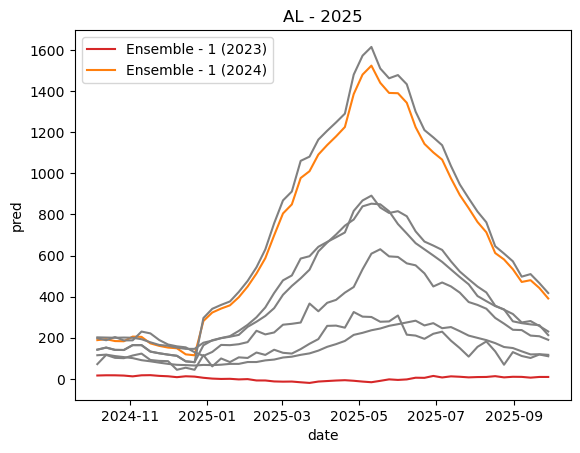

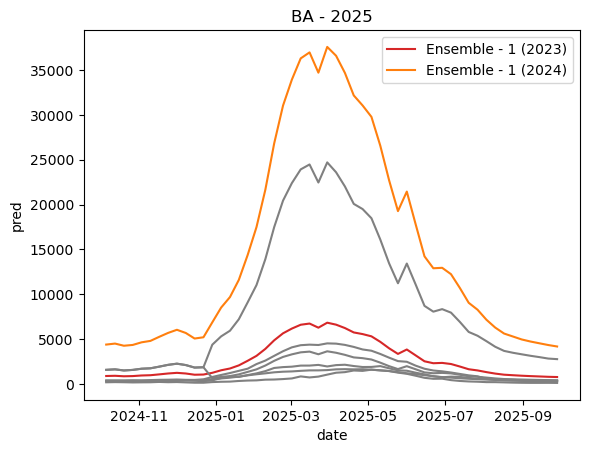

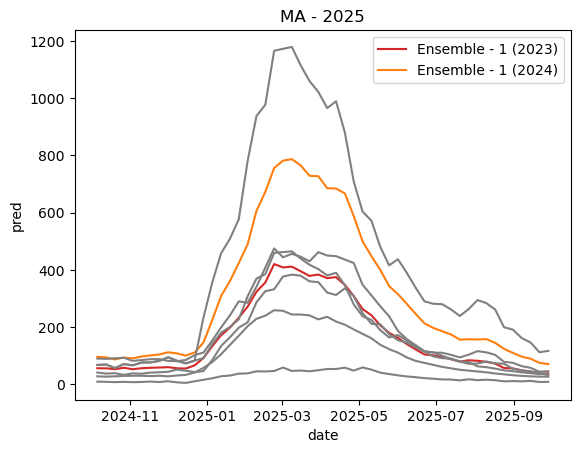

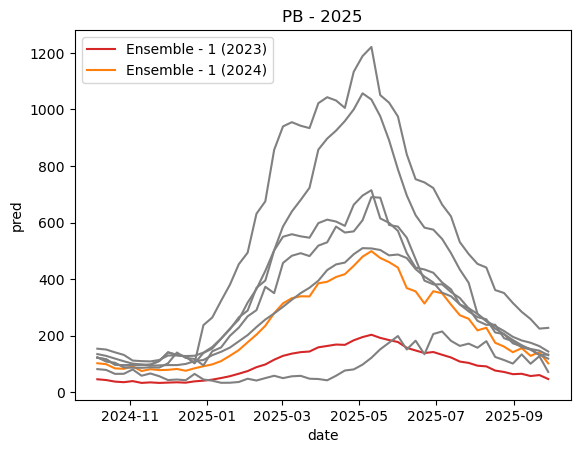

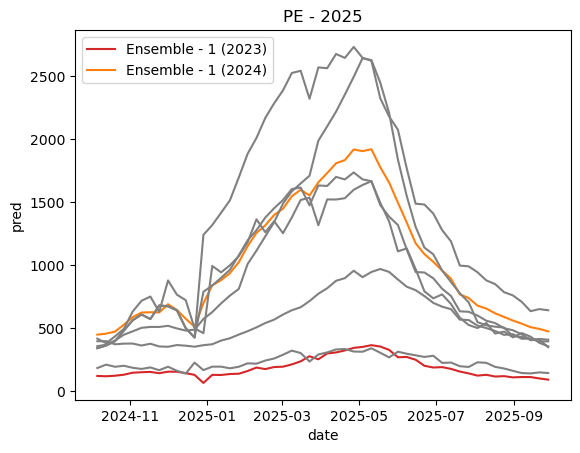

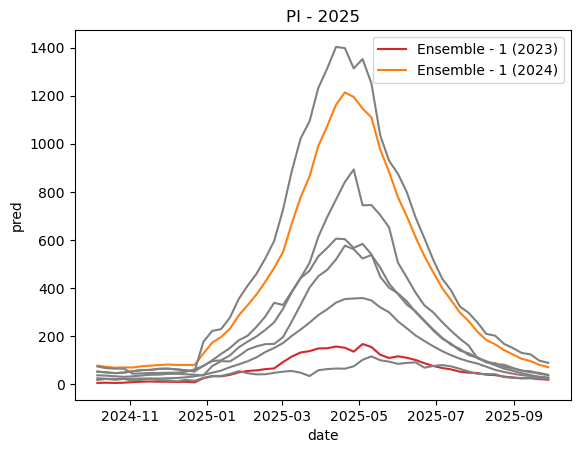

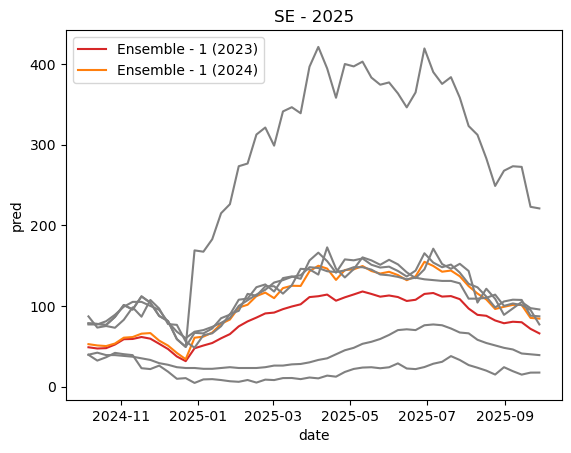

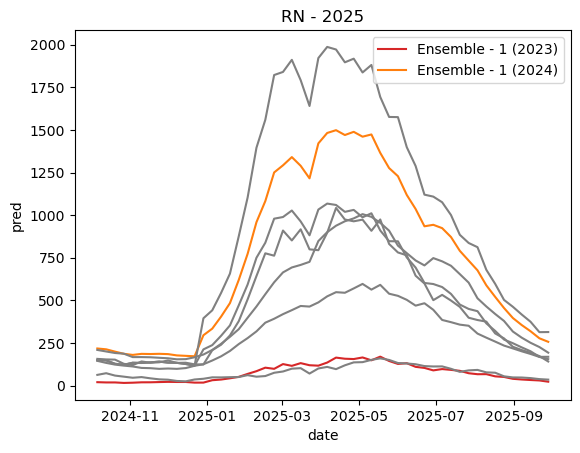

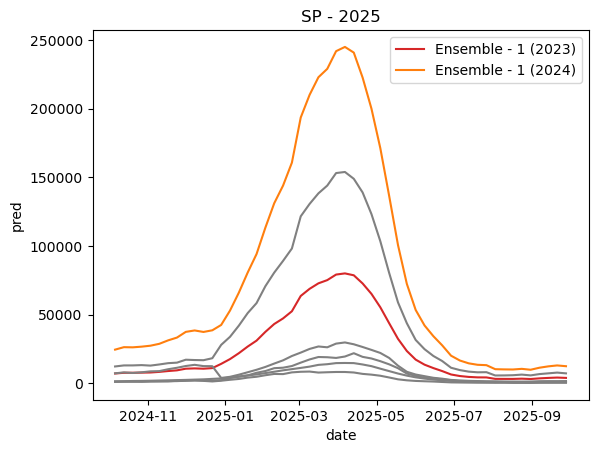

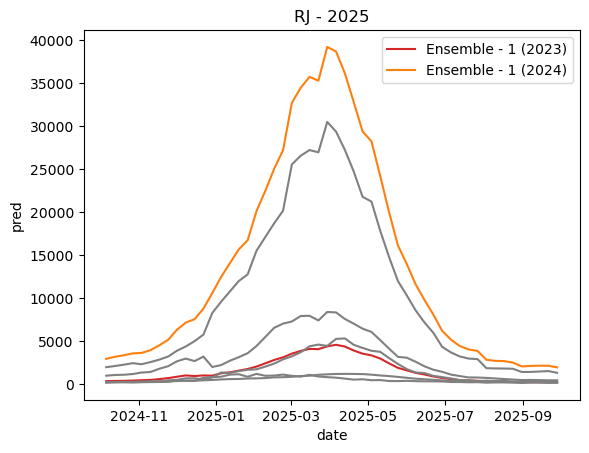

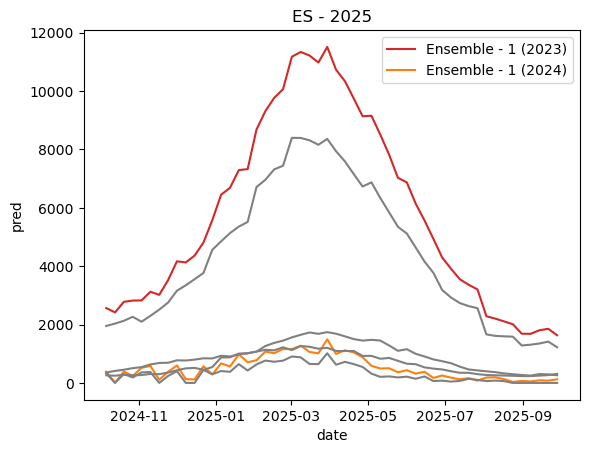

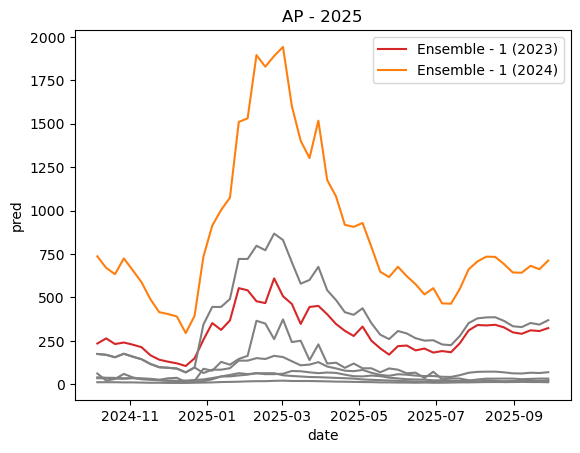

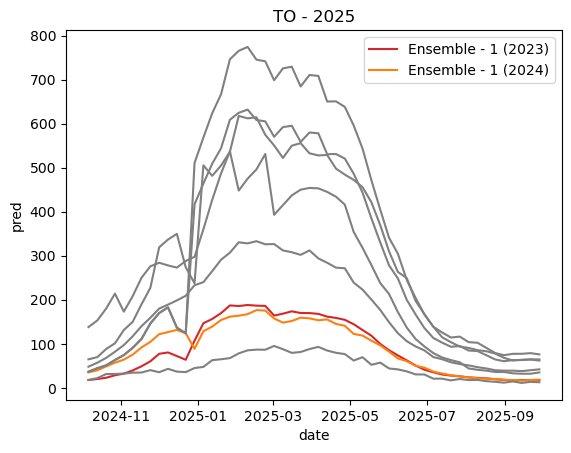

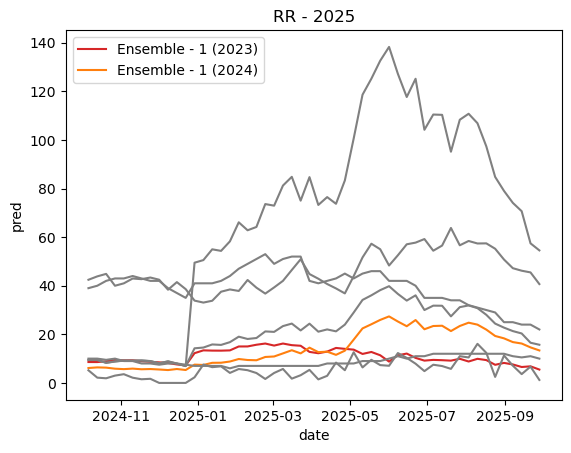

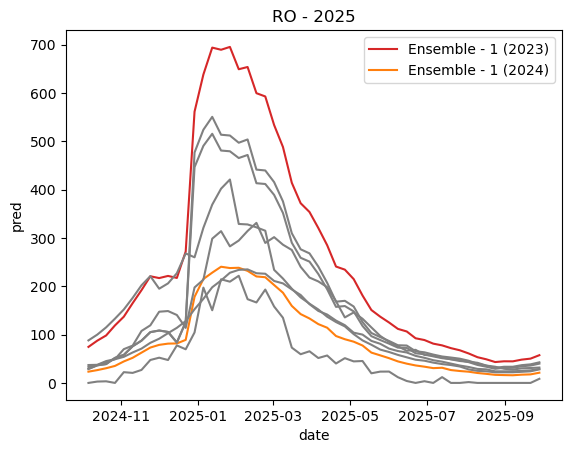

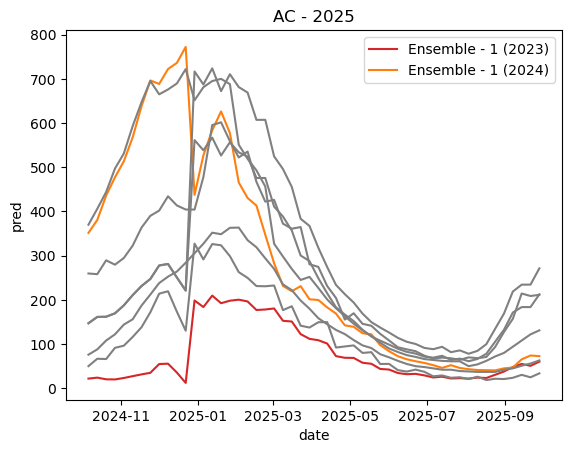

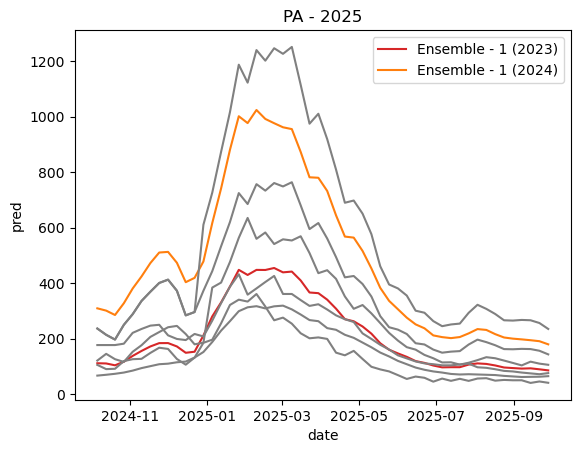

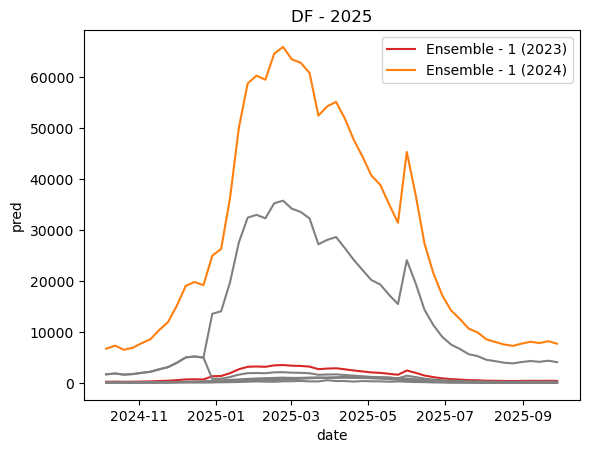

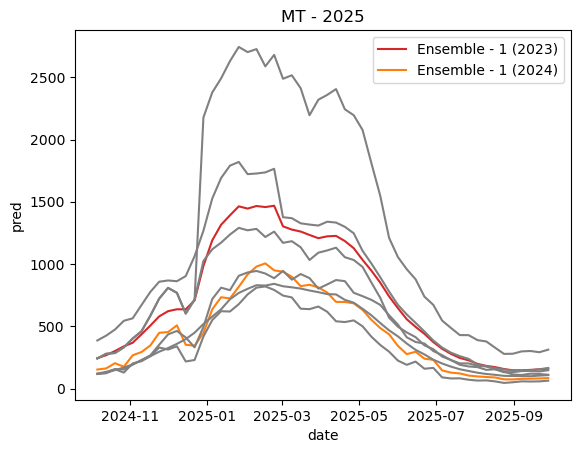

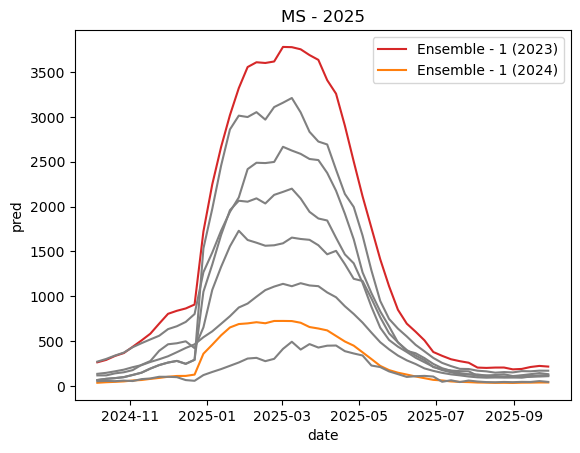

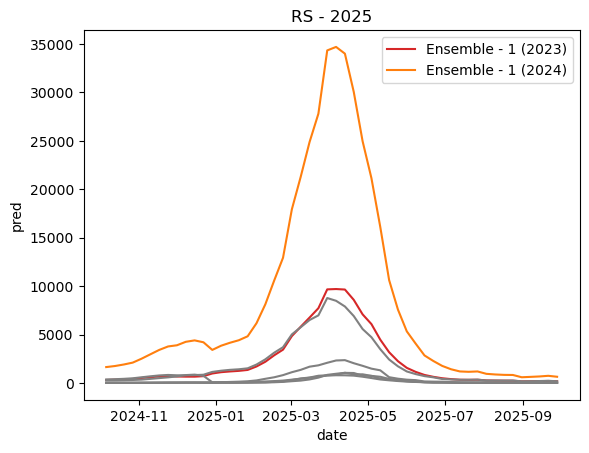

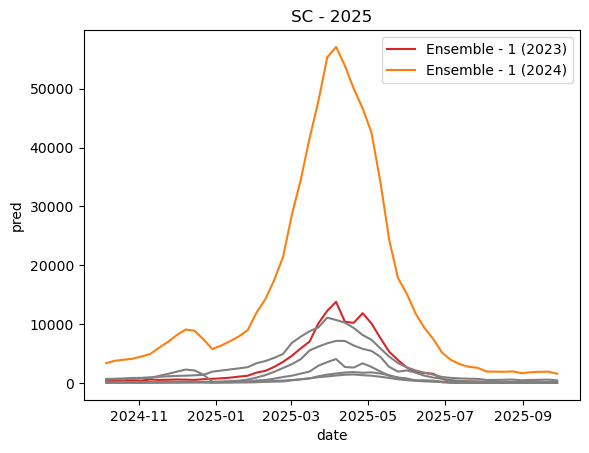

In [47]:
for state in df_forecast.state.unique(): 

    df_ = df_forecast.loc[df_forecast.state == state] 
    fig,ax = plt.subplots()

    ax.plot(df_.date, df_.ensemble_2023, color = 'tab:red', label = 'Ensemble - 1 (2023)', linewidth = 1.5)

    ax.plot(df_.date, df_.ensemble_2024, color = 'tab:orange', label = 'Ensemble - 1 (2024)', linewidth = 1.5)

    sns.lineplot(ax=ax, x = 'date', y = 'pred',   legend = False, units="model_id", estimator=None, 
         color = 'grey', data = df_preds_all.loc[(df_preds_all.date.isin(dates_25)) & (df_preds_all.state == state)])
    
    ax.set_title(f'{state} - 2025')

    ax.legend()

    #plt.savefig(f'./figures/ensemble_{state}.png')
    
    plt.show()
